<h3>Machine Learning. Project 1</h3>

<h4>Group</h4>
<ul>
    <li>Mikhail Mironov</li>
    <li>Ilyuk Alexander</li>
</ul>


<p>The dataset is about a company from Barcelona that wishes to predict engine-off time betweeen deliveries, essentially how much time it takes to unload the truck and do the delivery</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import seaborn as sns

from typing import *
from tqdm import tqdm

%matplotlib inline

<p>We have a typical regression problem on our hands where we aim to predict some numeric variable (in our case <b>final_time</b>) with other predictor variables.</p>
<p>Machine learning allows to train a model on existing data and use this model to make future predictions that if done properly are very close to reality. This allows to know beforehand how much time it is going to take to unload the car which in its turn allows to have more predictable delivery time for clients.</p>

<h3>Preliminary analysis</h3>

In [2]:
# load data
df = pd.read_csv("dropoffs_df.csv")
df.head(1)

,client_name,truck_size,truck_origin_warehouse,delivery_timestamp,total_weight,brand_1_coffee_proportion,driver_id,is_fresh_client,postcode,business_category,floor,partnership_level,box_count,brand_2_coffee_proportion,brand_3_coffee_proportion,final_time
0,Amigó Ltd,Van,Baró de Viver,2022-04-28 18:56:43,9.86,0.85,D84,False,8030,Cafe/Restaurant,Street level,Regular,2,0.003478,0.146522,231.423355


In [3]:
# we have no missing values
df.isna().sum().sum()

0

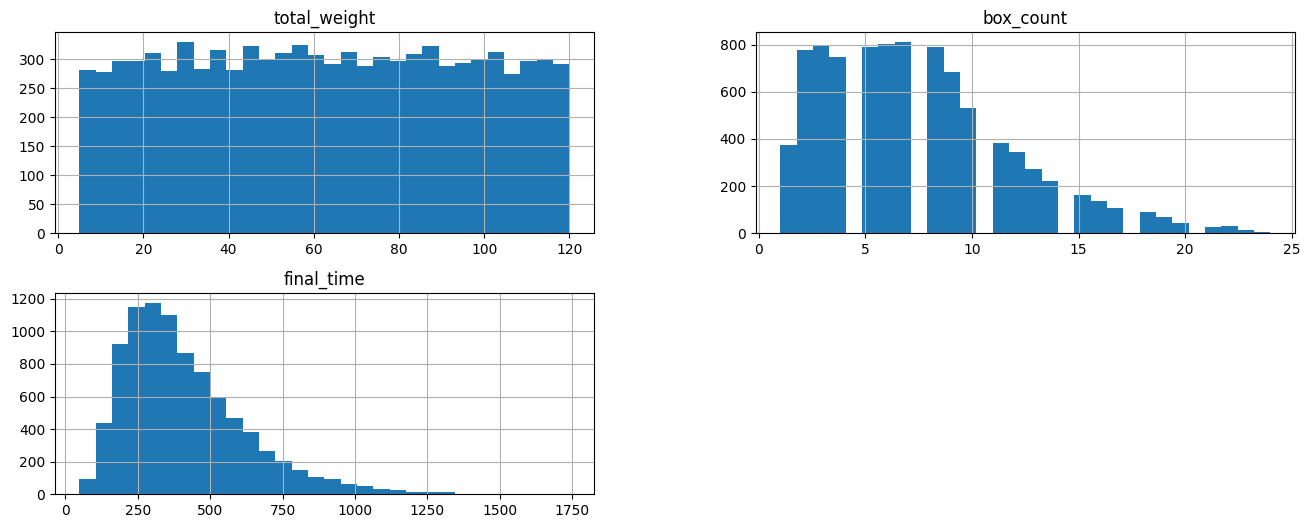

In [4]:
df[["total_weight", "box_count", "final_time"]].hist(bins=30, figsize=(16, 6))
plt.show()

<p>The data is clean. We observe that numeric variables don't have very huge outliers. High values of both box_count and final_time variables seem to be reasonable.</p>

<h4>Studying current estimate of 3 minutes engine-off time</h4>

Basically we have a prediction of $\hat{y_i} = 180$ seconds which we can compare with other models. Here we will use MAPE (Mean Absolute Percentage Error) as an evalution metric. It allows to see how the error in the engine-off time compares to the absolute value of engine-off time.

In [5]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

In [6]:
y_pred = np.full(df.shape[0], 3*60) # previous estimates
y_true = df.final_time

current_perf = {
    "MAE": mean_absolute_error(y_pred=y_pred, y_true=y_true),
    "MSE": mean_squared_error(y_pred=y_pred, y_true=y_true),
    "RMSE": mean_squared_error(y_pred=y_pred, y_true=y_true, squared=False),
    "MAPE": mean_absolute_percentage_error(y_pred=y_pred, y_true=df.final_time),
    "R2": r2_score(y_pred=y_pred, y_true=y_true)
}


pd.DataFrame(current_perf.values(), index=current_perf.keys()).T

d:\SOQ\ML\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,MAE,MSE,RMSE,MAPE,R2
0,239.722643,100664.181558,317.276191,0.489676,-1.176726


<p>This means that on average with this approach we miss the real engine-off time by 49%</p>

<h4>Studying time variables</h4>

In [7]:
df.delivery_timestamp = pd.to_datetime(df.delivery_timestamp)

<p>Here we will mostly prepare and study data that we have. We will study the features and do some feature engineering.</p>

<p>First we will start with creating <b>dummy variables</b> for all categorical variables. Since there are not that many categorical variables we are good to use dummies, dataset will not explode in its size. We will start with timestamp dummies that will encode month, weekday and hour. We will study if there is any relationship between time of the day and engine-off time. We presume that certain times of the day could be more crowded thus raising the amount of time needed for dropping-off the product. Also we will examine month dummies to check if there is any effect of the time of the year on engine-off time. We suppose it won't be any significant since there is no snow during the winter so it shouldn't have any effect.</p>

In [8]:
# split timestamp to days, hours and months and encode with dummies
df["delivery_weekday"] = df.delivery_timestamp.dt.weekday
df["delivery_day"] = df.delivery_timestamp.dt.day
df["delivery_month"] = df.delivery_timestamp.dt.month
df["delivery_hour"] = df.delivery_timestamp.dt.hour

<p>Below we create dummies representing each week in a months i.e 1st, 2nd, 3rd 4th weeks. We don't expect that it will have any effect, but we will check nevertheless.</p>

In [9]:
# create a dummy variable indicating each day of the week
day_dummies = pd.get_dummies(df["delivery_weekday"], prefix="weekday")
day_cols = day_dummies.columns.tolist()
df = pd.concat([df, day_dummies], axis=1)

In [10]:
# create dummies for intervals of days within a month (1-10) (10-20) (20-31) - (start, mid, end)
bin_days = [0, 7, 14, 21, 31]
labels = ["week_1", "week_2", "week_3", "week_4"]

df["delivery_day_cut"] = pd.cut(df["delivery_day"], bins=bin_days, labels=labels)
week_dummies = pd.get_dummies(df["delivery_day_cut"])
week_cols = week_dummies.columns.tolist()

df = pd.concat([df, week_dummies], axis=1)

In [11]:
# check delivery hours range to create bins below
np.sort(df.delivery_hour.unique())

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

<p>Above we have covered this, these variables indicating morning, day, evening are the most promising</p>

In [12]:
# create dummies for delivery hours to indicate morning, day, evening
bin_hours = [7, 12, 17, 21]
labels = ["morning", "day", "evening"]

df["delivery_hour_cut"] = pd.cut(df["delivery_hour"], bins=bin_hours, labels=labels)
hour_dummies = pd.get_dummies(df["delivery_hour_cut"])
hour_cols = hour_dummies.columns.tolist()

df = pd.concat([df, hour_dummies], axis=1)

<p>By creating <b>is_holiday</b> variable indicating holidays and weekends in Barcelona we can examine how holidays and weekends affect engine-off time. Employees might be more relaxed during these days as one of the possible relationships. But honestly, we don't expect this to be significant.</p>

In [13]:
# create a binary variable is_holiday (namely in Barcelona)
barcelona_holidays = holidays.Spain(prov="CT")
barcelona_business_days = pd.offsets.CustomBusinessDay(holidays=barcelona_holidays)

sorted_dt = df.delivery_timestamp.sort_values()

date_range = pd.bdate_range(
    start=sorted_dt.iloc[0], end=sorted_dt.iloc[-1], freq=barcelona_business_days
)

date_range = [
    el.date() for el in date_range
]

In [14]:
def is_holiday(el) -> int:
    return int(el.date() in date_range)

df["is_holiday"] = df.delivery_timestamp.apply(is_holiday)

<p>Month dummies. Since we have 5 months starting from January to May. It is basically same as <b>is_winter</b> boolean. We also don't expect this to be any significant since there is no snow in Barcelona and it doesn't get in a way of delivery itself when driver has to go through a bunch of snow.</p>

In [15]:
df["is_winter"] = 0
df.loc[df.delivery_timestamp.dt.month <= 2, "is_winter"] = 1

<p>Now we will visualise these dummies and their relationship with engine-off time</p>

In [16]:
time_cols = week_cols + day_cols + hour_cols + ["is_holiday", "is_winter"]

In [17]:
def q5(x):
    return x.quantile(.05)

def q95(x):
    return x.quantile(.95)

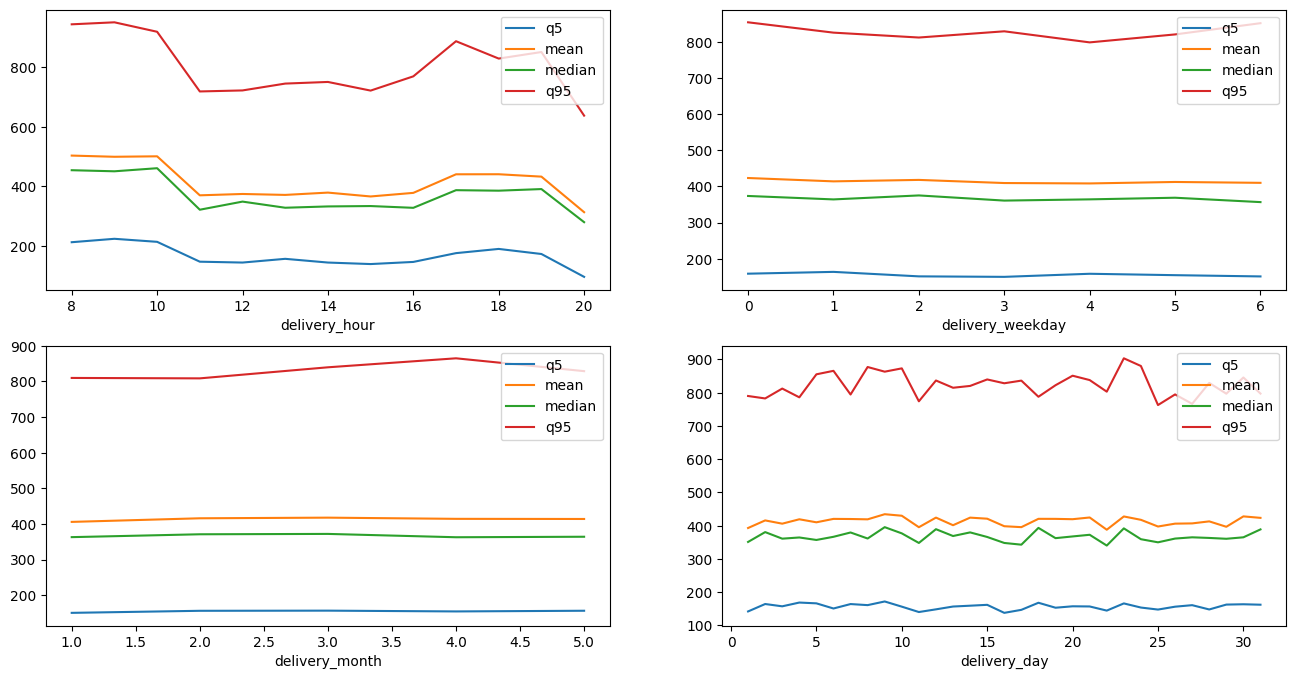

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# groupby hours, weekdays and etc and plot 
df.groupby("delivery_hour")["final_time"].agg([q5, "mean", "median", q95]).plot(ax=axs[0][0])
df.groupby("delivery_weekday")["final_time"].agg([q5, "mean", "median", q95]).plot(ax=axs[0][1])

df.groupby("delivery_month")["final_time"].agg([q5, "mean", "median", q95]).plot(ax=axs[1][0])
df.groupby("delivery_day")["final_time"].agg([q5, "mean", "median", q95]).plot(ax=axs[1][1])

# plt.savefig("dt_final_time.png", bbox_inches="tight")
plt.show()

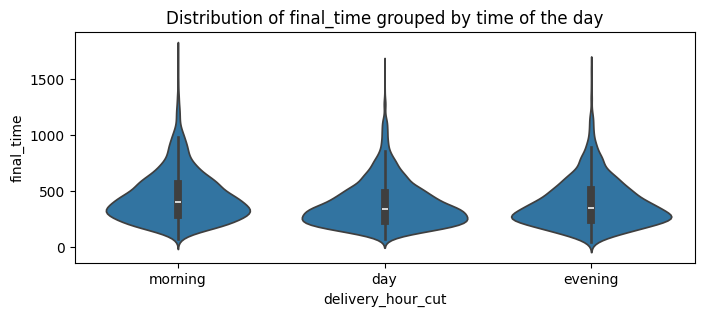

In [19]:
plt.figure(figsize=(8, 3))
plt.title("Distribution of final_time grouped by time of the day")
sns.violinplot(df, x="delivery_hour_cut", y="final_time")
plt.show()

<p>There is no significant effect of <b>delivery_weekday</b>, <b>delivery_month</b> and <b>delivery_day</b> varibles on engine-off time since there is no noticable changes in boundaries of 95% confidence interval along with no changes in mean and median.</p>

<h4>Order entropy</h4>
<p>To account for how difficult it is get the order right we quantify its complexity with entropy. We assume that driver might need to handle multiple different packages or boxes when there are multiple brands of coffee. This makes it necessary to both double check if the order is assembled correctly by both driver and receiving client.</p>

<p>The higher the value of entropy the more complex the order is.</p>

$
    H(x) = \sum_{i=1}^{n}{-p_{i}\log_{2}{p_{i}}}
$

In [20]:
def order_entropy(proportions: List[float]) -> float:
    res = 0
    for prob in proportions:
        if prob == 0:
            return 0
        res += -prob * np.log(prob) / np.log(2) / (np.log(3) / np.log(2))
    
    return res

In [21]:
cols_brands = ["brand_1_coffee_proportion", "brand_2_coffee_proportion", "brand_3_coffee_proportion"]

df["brand_distr"] = df[cols_brands].values.tolist()
df["order_entropy"] = df.brand_distr.apply(order_entropy)

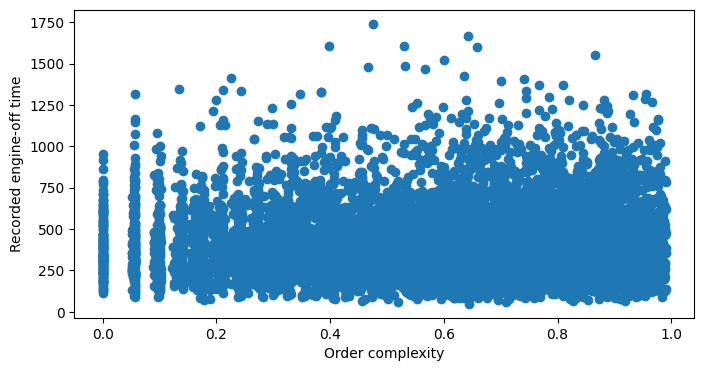

In [22]:
plt.figure(figsize=(8, 4))
plt.scatter(df["order_entropy"], df["final_time"])
plt.xlabel("Order complexity")
plt.ylabel("Recorded engine-off time")
plt.show()

<p>I wouldn't say that there is any significant effect of order complexity. But we see that simpler orders allow to cap upper quantile at around 1000.</p>

<h4>Truck related columns</h4>
<p>From the grouped table below we see that values from the whole distribution for engine-off time for trucks are slightly bigger than others, meaning that we can say for certain, having a truck affects the final engine-off time.</p>

In [24]:
df.groupby("truck_size")["final_time"].agg([
    q5, "mean", "median", q95
]).style.background_gradient(axis=0)

,q5,mean,median,q95
truck_size,,,,
Combi,143.196328,388.601745,346.688484,793.864542
Truck,163.555276,432.898299,375.546289,875.642797
Van,157.960940,419.006186,372.828234,829.068524


In [25]:
truck_dummies = pd.get_dummies(df["truck_size"])
truck_cols = truck_dummies.columns.tolist()

df = pd.concat([df, truck_dummies], axis=1)

<h4>Floor columns</h4>
<p>Variables related to floor of the client definately have a direct effect on engine-off time. The higher the floor is the more time it takes to get there. The relationship might not be linear especially if there is no elevator.</p>

In [26]:
floor_dummies = pd.get_dummies(df["floor"])
floor_cols = floor_dummies.columns.tolist()

In [27]:
df.groupby("floor")["final_time"].agg([
    q5, "mean", "median", q95
]).style.background_gradient(axis=0)

,q5,mean,median,q95
floor,,,,
Ground Floor,178.491750,453.118526,410.373316,898.678435
Other,211.447491,522.424233,481.032836,1012.762866
Street level,146.663865,390.878883,344.966308,788.753089


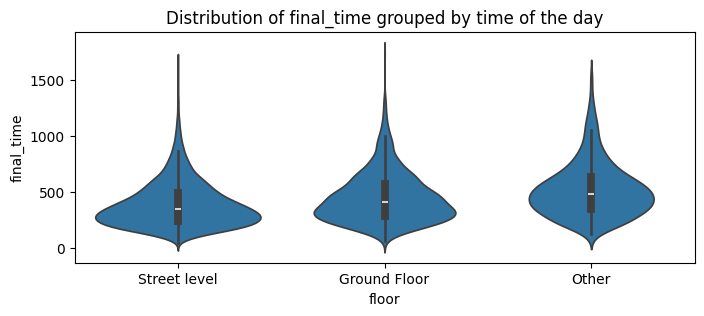

In [28]:
plt.figure(figsize=(8, 3))
plt.title("Distribution of final_time grouped by time of the day")
sns.violinplot(df, x="floor", y="final_time")
plt.show()

In [29]:
df = pd.concat([df, floor_dummies], axis=1)

<h4>Client business columns</h4>
<p>Type of business that client does shouldn't affect the final time. As we see from distributions and table below, they are almost identical, indicating that there is close to none impact of business_category variable.</p>

In [30]:
df.groupby("business_category")["final_time"].agg([
    q5, "mean", "median", q95
]).style.background_gradient(axis=0)

,q5,mean,median,q95
business_category,,,,
Cafe/Restaurant,154.328164,414.533338,369.065458,835.291573
Coffee Retailers,151.300228,408.587521,360.627390,789.034176
Hotels,156.562181,408.654297,352.583201,829.938104


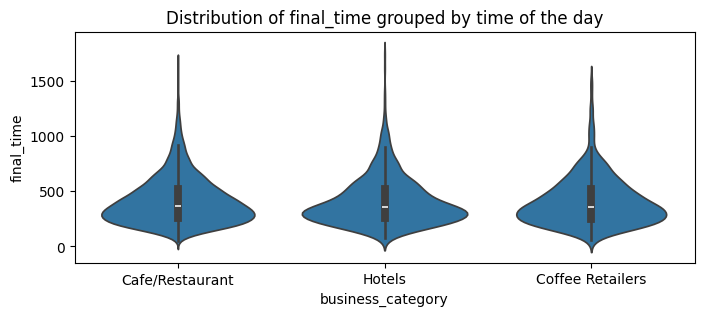

In [31]:
plt.figure(figsize=(8, 3))
plt.title("Distribution of final_time grouped by time of the day")
sns.violinplot(df, x="business_category", y="final_time")
plt.show()

In [32]:
client_business_dummies = pd.get_dummies(df.business_category)
client_business_cols = client_business_dummies.columns.tolist()

df = pd.concat([df, client_business_dummies], axis=1)

<h4>Dummies for each worker</h4>
<p>This one is very promising since there is a simple intuition behind the relationship of driver and engine-off time. Mainly we are looking at their physical capabilities, one can take all of the boxes and drop them off in one go, whilst the other one might take multiple runs to carry everything. So this one should be significant.</p>

In [33]:
driver_dummies = pd.get_dummies(df["driver_id"])
driver_cols = driver_dummies.columns.tolist()

df = pd.concat([df, driver_dummies], axis=1)

In [34]:
# there are plenty of them we will do correlation plot to see if there is any 
# significant effect on engine-off time
df.driver_id.unique()

array(['D84', 'D98', 'D18', 'D13', 'D9', 'D61', 'D16', 'D58', 'D64',
       'D49', 'D27', 'D33', 'D63'], dtype=object)

In [35]:
df_drivers = df.groupby("driver_id")["final_time"].agg(
    [q5, "mean", "median", q95]
)

df_drivers["mean_weight_handled"] = df.groupby("driver_id")["total_weight"].mean()
df_drivers.round(2)

,q5,mean,median,q95,mean_weight_handled
driver_id,,,,,
D13,252.55,548.64,505.96,1019.13,62.84
D16,231.38,496.70,450.58,941.21,60.51
D18,197.25,456.15,403.40,885.89,62.14
D27,203.63,459.28,420.81,840.73,63.35
D33,105.70,285.27,256.07,550.54,61.55
D49,158.87,372.63,336.18,705.68,62.39
D58,192.82,433.85,400.27,793.25,62.50
D61,157.84,399.21,349.02,782.83,62.72
D63,285.77,608.66,553.59,1117.50,63.05


<p>From the table we can clearly see that drivers have on average the same total_weight but still they have different engine-off times which indicate that there is some individual effects that affect final times.</p>

<h4>Dummies for each postcode (each location)</h4>
<p>This one is more questionable but still different locations might have something specific about them such as a minimum distance between parking spaces and the location itself. One location might be slightly futher from the road than others, or some might have a dedicated parking spots for unloading whilst others don't have these. </p>

In [36]:
postcode_dummies = pd.get_dummies(df["postcode"])
postcode_cols = [f"postcode_{el}" for el in postcode_dummies.columns]

postcode_dummies.columns = postcode_cols

df = pd.concat([df, postcode_dummies], axis=1)

<h4>Partnership level dummies</h4>
<p>Clients being a higher ranked account might have less paperwork and overall overhead related to receiving a delivery. But most likely there is no such complex relationships, so this variable could be just ignored.</p>

In [37]:
partnership_dummies = pd.get_dummies(df["partnership_level"])
partnership_cols = partnership_dummies.columns.tolist()

df = pd.concat([df, partnership_dummies], axis=1)

<h4>Cyclical time. Days and Hours</h4>

In [38]:
total_day_seconds = 24*60*60

In [39]:
# cyclical hours to account that 6 am and 22 pm are close to each other
df["day_seconds_elapsed"] = pd.to_timedelta(
    df.delivery_timestamp.dt.time.astype(str)
).dt.total_seconds()

df["sin_time"] = np.sin(2*np.pi*df.day_seconds_elapsed / total_day_seconds)
df["cos_time"] = np.cos(2*np.pi*df.day_seconds_elapsed / total_day_seconds)

In [40]:
# same for days 0 and 6 are close not 7 days apart
df["sin_day"] = np.sin(2*np.pi*df.delivery_weekday / 7)
df["cos_day"] = np.cos(2*np.pi*df.delivery_weekday / 7)

<h2>Task 2</h2>

<p><b>Task 2.1</b> Present how are you going to measure performance for this problem and
how you will use the available data for testing it.</p>

<p>We will use 80-20 train test split. First 80 % of the data is a train set that is used for training of the model. The other 20 % are used to test the model, and it should not be used for any hyperparamter tuning and comparison of the models. Otherwise we are just adjusting our models so it yields the best results which creates bias meaning our model is not generalising. This might lead to the model being completely wrong once run in the production.</p>
<p>In order to tune models and choose the best ones we will do Repeated K-Fold crossvalidation. This will allow us to save up on training data as we don't have to create another separate validation set. Also such approach allows to control overfitting as choosing models and tuning their hyperparameters on some predefined validation set might result in overfitting because left-out validation set might be not representitive of the general population. Moreover, we will use repeated crossvalidation meaning that we will create multiple variations of K-Folds which eliminates risk of being just lucky with folds we get for validation.</p>

<p>Speaking of choosing an appropriate loss function, we will go for either MSE (Mean squared error) or Huber Loss, ideally I would choose MAPE as a loss funciton but sklearn doesn't support it out of the box. So we will use it as an evaluation metric to tune the parameters and compare the models between each other.</p>

<p>We will not scale the data, this messes up MAPE score if we standardize to zero.</p>

In [41]:
from sklearn.model_selection import RepeatedKFold, cross_validate

In [42]:
# fold generator that will be used to compare models between each other
cv_fold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

In [43]:
# choosing scoring metrics that we will look at to compare models between each other
scoring = (
    "neg_mean_absolute_error",
    "neg_mean_squared_error",
    "neg_root_mean_squared_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)

In [44]:
num_cols = [
    "total_weight", "box_count",
    "order_entropy",
]

binary_default = ["is_holiday", "is_fresh_client", "is_winter"]

<p><b>2.2</b> Develop a baseline algorithm and evaluate its performance.</p>
<p>As a baseline model we will go for a simple linear regression with numeric variables provided in initial dataset. This will enable us to see how baseline linear regression without any tuning and feature engineering compares to more sophisticated models that we devise later.</p>

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [46]:
df_train, df_test = train_test_split(
    df, train_size=0.8, shuffle=True, random_state=42
)

<h4>Baseline model. Linear regression with variables that make sense to use.</h4>
<p>This set of features contains the variables that should have an impact on the target variable</p>

In [47]:
reg_cols = (
    ["box_count", "is_fresh_client"] + driver_cols + hour_cols + truck_cols + floor_cols
)

In [48]:
lr_baseline = LinearRegression()

lr_baseline.fit(df_train[reg_cols], df_train["final_time"])

LinearRegression()

<p>Below we are using $R^{2}$ metric to evaluate our trained model. $R^{2}$ allows us to quantify how much variance in the engine-off time we are able to predict using our model. Alternatively, it is the measure of how better the model is than a dummy estimator that just outputs the mean.</p>

$
    R^{2} = 1 - \frac{\sum_{i=1}^{n}{(y_i - \hat{y_i})^2}}{\sum_{i=1}^{n}{(y_i - \bar{y_i})^2}} = 1 - \frac{SSE_{pred}}{SSE_{total}}
$

<p>$R^2$ is a great metric for checking how good the fit of the model is but still it is very easy to mess up because by adding more meaningless variance with new features that don't make any sense will improve $R^2$. Therefore, we might use something like adjusted-$R^2$ which penalises overly complicated models that have multiple regressor variables.</p>

In [49]:
def adjusted_r2_score(y_true, y_pred, ddof):
    return 1 - (1 - r2_score(y_true, y_pred)) * (y_pred.shape[0] - 1) / (y_pred.shape[0] - ddof)

In [50]:
res = cross_validate(
    lr_baseline, df_train[reg_cols], df_train["final_time"], scoring=scoring, cv=cv_fold
)

lr_cv = pd.DataFrame(res)
lr_cv.agg([q5, "mean", "median", q95], axis=0)

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error,test_r2
q5,0.003055,0.001000,-72.062495,-9638.031343,-98.171702,-0.204028,0.794524
mean,0.006416,0.001865,-69.413079,-8732.686604,-93.411093,-0.194783,0.807812
median,0.005026,0.002001,-69.063902,-8692.838365,-93.235392,-0.193873,0.809401
q95,0.010915,0.003411,-67.030236,-7956.922170,-89.201228,-0.187884,0.820012


<h2>Task 3</h2>

<p><b>Task 3.1</b> Develop the best model you can make to predict engine-off time.</p>

<h3>Linear regression based models</h3>

<h4>Linear regression with dummies</h4>
<p>Below we are trying to fit all of the variables presented above, this will for sure increase $R^{2}$ score but this is not necessarily a good thing. On top of that, there is plenty of multicollinearity which messes up coefficients of our regression and therefore interpretability, we will observe that some of the coefficients are in millions despite the fact that all regressors are scaled this is indicative of such multicollinearity. Further we will fix it using LASSO regression.</p>

In [51]:
# define regressor columns
reg_cols = (
    num_cols + binary_default + day_cols + week_cols + hour_cols + truck_cols + partnership_cols +
    floor_cols + client_business_cols + driver_cols + postcode_cols
)

In [52]:
lr = LinearRegression() # MSE loss function

lr.fit(df_train[reg_cols], df_train["final_time"])

LinearRegression()

In [53]:
res = cross_validate(
    lr, df_train[reg_cols], df_train["final_time"], scoring=scoring, cv=cv_fold
)

lr_cv = pd.DataFrame(res)
lr_cv.agg([q5, "mean", "median", q95], axis=0)

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error,test_r2
q5,0.016221,0.001610,-72.640161,-9768.393442,-98.833292,-0.205018,0.793264
mean,0.021918,0.002214,-69.966079,-8835.516487,-93.960800,-0.196531,0.805550
median,0.018030,0.002002,-69.878537,-8795.773018,-93.785783,-0.196069,0.806801
q95,0.029468,0.003011,-67.554485,-8046.183409,-89.700169,-0.189862,0.816715


In [54]:
pd.DataFrame(
    lr.coef_, 
    index=reg_cols, 
    columns=["coef"]
).sort_values(by="coef", key=abs, ascending=False).head(10)

,coef
Truck,1.056784e+12
Van,1.056784e+12
Combi,1.056784e+12
Other,1.023140e+12
Ground Floor,1.023140e+12
Street level,1.023140e+12
weekday_4,-7.789527e+11
weekday_1,-7.789527e+11
weekday_3,-7.789527e+11
weekday_2,-7.789527e+11


<h4>LASSO Regression</h4>
<p>To fix the issue above we want to leave only significant variables that do have an effect on the target engine-off time. To achieve this we will add L1 penalty that will prevent assigning non-zero values to insignificant variables, this will induce sparsity to our solution making it more general.</p>

$
    Loss \,\, function = \sum_{i=1}^{n}{(y_i - \hat{y_i})^2} + \alpha\sum_{j=1}^{k}{|\beta_j|}
$

<p>Parameter $\alpha$ defines how heavily we penalise non-sparsity, the higher alpha the more significant variables will remain.</p>

In [55]:
from sklearn.linear_model import Lasso

In [56]:
ls = Lasso(alpha=0.01,  max_iter=10000)
ls.fit(df_train[reg_cols], df_train["final_time"])

Lasso(alpha=0.01, max_iter=10000)

In [57]:
res = cross_validate(
    ls, df_train[reg_cols], df_train["final_time"], scoring=scoring, cv=cv_fold
)

ls_cv = pd.DataFrame(res)
ls_cv.agg([q5, "mean", "median", q95], axis=0)

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error,test_r2
q5,0.271725,0.002031,-72.597544,-9761.006286,-98.795928,-0.204886,0.793340
mean,0.316688,0.003076,-69.913937,-8827.421207,-93.917468,-0.196332,0.805730
median,0.318261,0.003011,-69.812493,-8791.487998,-93.762935,-0.195816,0.806995
q95,0.379296,0.004189,-67.501194,-8037.365026,-89.651025,-0.189644,0.816926


<p>As we see, we were right about the selection of the variables, LASSO puts highest coefficients on the most significant variables same as we discussed earlier while having basically the same stats. Since we didn't do any scaling of the data, we have perfect interpretability with LASSO regression. Therefore, now we are safe to use the same set of variables that we used for Baseline model.</p>

In [58]:
pd.DataFrame(
    ls.coef_, 
    index=reg_cols, 
    columns=["coef"]
).sort_values(by="coef", key=abs, ascending=False).head(20)

,coef
D98,-158.299172
D63,155.874800
D33,-148.458963
is_fresh_client,135.719595
D13,111.557625
Street level,-72.973384
Other,67.160389
D16,66.281019
morning,60.764846
D49,-58.604495


<p>As we can see from above out of binary variables only driver, floor and time of the day related columns are relevant, from numeric we are safe to choose one like box_count.</p>

<h4>Huber Regressor</h4>

<p>MSE is very sensetive to outliers which might skew the whole regression towards outliers. This might be a good thing if we want to predict those better accepting a bit higher loss for inliers. But instead we could just use robust Huber Loss which is the middleground between MSE and MAE, it allows to still put stress on more or less correctly predicting outliers at the same time not increasing loss for inliers that much.</p>

<div>
    <img src="huberloss.png" width="400">
</div>

<p>Above is the function of huber loss, we see that it is quadratic for smaller errors and linear for bigger errors.</p>

$
    {\displaystyle L_{\delta }(a)={\begin{cases}{\frac {1}{2}}{a^{2}}&{\text{for }}|a|\leq \delta ,\\\delta \cdot \left(|a|-{\frac {1}{2}}\delta \right),&{\text{otherwise.}}\end{cases}}}
$

In [59]:
from sklearn.linear_model import HuberRegressor

In [60]:
hr = HuberRegressor(
    epsilon=1.35,
    max_iter=10000,
    alpha=0.01
)

hr.fit(df_train[reg_cols], df_train["final_time"])

HuberRegressor(alpha=0.01, max_iter=10000)

In [61]:
res = cross_validate(
    hr, df_train[reg_cols], df_train["final_time"], scoring=scoring, cv=cv_fold
)

ls_cv = pd.DataFrame(res)
ls_cv.agg([q5, "mean", "median", q95], axis=0)

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error,test_r2
q5,0.786175,0.001901,-71.291145,-9879.841295,-99.396832,-0.196821,0.790634
mean,0.994560,0.002116,-68.898800,-8966.291372,-94.648204,-0.188614,0.802724
median,0.996602,0.002000,-68.830268,-8901.781529,-94.349253,-0.188304,0.804317
q95,1.189975,0.002935,-66.385320,-8114.488155,-90.080410,-0.181132,0.813277


<h3>Tree based models</h3>

<p>First we will start off with bagging - RandomForest where we ensemble multiple week learners to make a collective good prediction. To tune the hyperparameters of RandomForest we will use optuna package that will allow in better fashion go through multiple configurations of the model and select the best one - one that yields highest scoring metric on crossvalidation.</p>

In [ ]:
#!pip install optuna

# here if you do rerun the notebook just grab the optimal parameters found by optuna

<h4>Random Forest Regressor</h4>

In [63]:
from sklearn.ensemble import RandomForestRegressor
from functools import partial
from sklearn.metrics import mean_squared_error

import optuna

In [64]:
tune_fold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

In [65]:
def random_forest_objective(
    trial: optuna.Trial, 
    df: pd.DataFrame, 
    reg_cols: List[str],
    fold: RepeatedKFold
):
    # define model with optuna set of hyperparameters
    rfr = RandomForestRegressor(
        criterion="squared_error",
        # max depth of grown trees, (it is typically better to have more of smaller trees so there is no overfit)
        max_depth=trial.suggest_int("max_depth", 2, 20), # adjust max depth to control overfitting
        # number of trees grown in our ensemble
        n_estimators=trial.suggest_int("n_estimators", 100, 1300, step=50),
        max_samples=trial.suggest_float("max_samples", 0.5, 1), # use not all observations to avoid overfit
    )
        
    mape_scores = []
    
    for train_idx, val_idx in fold.split(df[reg_cols], df["final_time"]):
        # split data to train and validation sets
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # train on train subset and use validation set to evaluate the model
        rfr.fit(df_train[reg_cols], df_train["final_time"])
        y_pred = rfr.predict(df_val[reg_cols])
        
        mape_scores.append(mean_absolute_percentage_error(
            y_true=df_val["final_time"], y_pred=y_pred
        ))
          
    return np.mean(mape_scores)

In [66]:
# to help algorithm to find an optimal solution faster we will leave the most impactful variables 
reg_cols = (
    ["box_count", "is_fresh_client"] + driver_cols + hour_cols + truck_cols + floor_cols
)

In [ ]:
# create an optuna study that will aim to find hyperparameters to minimize MAPE
study_rfr = optuna.create_study(direction="minimize")

study_rfr.optimize(
    partial(random_forest_objective, df=df_train, reg_cols=reg_cols, fold=tune_fold), 
    n_trials=20, n_jobs=-1
)

In [69]:
rfr = RandomForestRegressor(
    criterion="squared_error",
    **study_rfr.best_params
)

In [70]:
res = cross_validate(
    rfr, df_train[reg_cols], df_train["final_time"], scoring=scoring, cv=cv_fold
)

rfr_cv = pd.DataFrame(res)
rfr_cv.agg([q5, "mean", "median", q95], axis=0)

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error,test_r2
q5,5.346999,0.148197,-68.408699,-9259.743697,-96.227541,-0.175894,0.794173
mean,6.162214,0.167674,-66.048178,-8494.692790,-92.126811,-0.170830,0.812816
median,5.573807,0.157935,-66.069704,-8448.299813,-91.914633,-0.171939,0.812455
q95,9.486806,0.246408,-63.943421,-7769.298176,-88.143475,-0.163712,0.831310


<h4>Gradient Boosting Machine</h4>

<p>Another approach is boosting where we learn based on previous errors. So we learn sequantially by adding more trees that aim to decrease the error. This should outperform previous models, we will see this when we do crossvalidation of the models.</p>

In [71]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [72]:
def gbm_objective(
    trial: optuna.Trial, df: pd.DataFrame, reg_cols: List[str], fold: RepeatedKFold
): 
    
    global df_gbm 
    
    gbm_params = {
        "loss": "squared_error",
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 15), 
        # subsample both feautures and observations
        "max_features": trial.suggest_float("max_features", 0.5, 1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
    }
    
    # train gbm with maximum number of boosting rounds of 2000 if there is no improvement on validation set 
    # then stop boosting
    gbm = GradientBoostingRegressor(
        **gbm_params, n_estimators=2000,
        validation_fraction=0.05, n_iter_no_change=100,
    )
    # unfortunately we are losing 0.05*80% of the data to validation set to get optimal number of boosting rounds
    
    df_trial = pd.DataFrame(
        cross_validate(gbm, df[reg_cols], df["final_time"], scoring=scoring, cv=fold)
    )
    
    df_gbm = pd.concat([df_gbm, df_trial], axis=0) # update global dataframe with stats
    
    return -df_trial["test_neg_mean_absolute_percentage_error"].mean()

In [73]:
df_gbm = pd.DataFrame()

study_gbm = optuna.create_study(
    direction="minimize",
)

study_gbm.optimize(
    partial(gbm_objective, df=df_train, reg_cols=reg_cols, fold=tune_fold), 
    n_trials=40
)

[I 2024-04-21 05:36:44,357] Trial 39 finished with value: 0.16926969421229437 and parameters: {'learning_rate': 0.054923849707795895, 'max_depth': 2, 'max_features': 0.6255472172622282, 'subsample': 0.6146032944228614}. Best is trial 37 with value: 0.16294208389290327.


In [74]:
gbm = GradientBoostingRegressor(
    **study_gbm.best_params, n_estimators=5000, 
    validation_fraction=0.05, n_iter_no_change=100
)

res = cross_validate(
    gbm, df_train[reg_cols], df_train["final_time"], scoring=scoring, cv=cv_fold
)

gbm_cv = pd.DataFrame(res)
gbm_cv.agg([q5, "mean", "median", q95], axis=0)

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error,test_r2
q5,0.391647,0.005008,-64.256977,-8162.317779,-90.345402,-0.168474,0.814202
mean,0.657266,0.008380,-62.442759,-7547.546811,-86.844575,-0.163128,0.833664
median,0.553049,0.007007,-62.419430,-7583.985292,-87.086080,-0.163525,0.833626
q95,1.011741,0.015325,-60.877246,-6928.746229,-83.239003,-0.157459,0.851647


<h4>Crossvalidate all of the models</h4>
<p>To compare the perfomance of the models we will crossvalidate them with the same fold generator, this way we will be able to see how the models compare to each other on the same sets in terms of various metrics</p>

In [75]:
from sklearn.metrics import (
    mean_absolute_percentage_error, mean_squared_error, 
    r2_score, mean_absolute_error
)

In [76]:
def crossval_models(
    models: List[Dict[str, Any]], df: pd.DataFrame, fold: RepeatedKFold
):
    preds = []
    i = 0
    
    for train_idx, val_idx in fold.split(df[reg_cols], df["final_time"]):
        # split data to train and validation sets
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        
        for model_cfg in models:
            model, model_name, cols = model_cfg["model"], model_cfg["name"], model_cfg["cols"]
            model.fit(df_train[cols], df_train["final_time"])
            preds.append({
                "model": model_name, "y_pred": model.predict(df_val[cols]),
                "y_true": df_val["final_time"],
                "fold": i
            })
            
        i += 1
            
    return pd.DataFrame(preds).explode(["y_true", "y_pred"])

In [77]:
res_cv = crossval_models(
    models=[
        {"name": "Linear Regression Baseline", "model": lr_baseline, "cols": reg_cols},
        {"name": "Lasso Regression", "model": ls, "cols": reg_cols},
        {"name": "Random Forest Regressor", "model": rfr, "cols": reg_cols},
        {"name": "Gradient Boosting Machine", "model": gbm, "cols": reg_cols}
    ], 
    df=df_train,
    fold=cv_fold
)

In [78]:
fold_res = []

for name, df_group in res_cv.groupby(["model", "fold"]):
    mape = mean_absolute_percentage_error(y_pred=df_group["y_pred"], y_true=df_group["y_true"])
    rmse = mean_squared_error(
        y_pred=df_group["y_pred"], y_true=df_group["y_true"]
    )
    r2 = r2_score(y_pred=df_group["y_pred"], y_true=df_group["y_true"])
    mae = mean_absolute_error(y_pred=df_group["y_pred"], y_true=df_group["y_true"])
    
    fold_res.append({
        "model": name[0], "fold": name[1], 
        "mape": mape,
        "mse": rmse,
        "r2_score": r2,
        "mae": mae
    })

<h4>Studying crossvalidation results</h4>

In [79]:
df_cross = pd.DataFrame(fold_res).groupby("model")[["mape", "mse", "r2_score", "mae"]].agg(
    [q5, "mean", "median", q95]
).T
df_cross.style.background_gradient(axis=1)

<h4>Distribution of errors</h4>
<p>Below we observe that all of the models are good, errors are distributed normally with mean of 0. Also 5 and 95 quantiles are smaller in terms of absolute value for GBM meaning it makes less extreme errors which is good.</p>

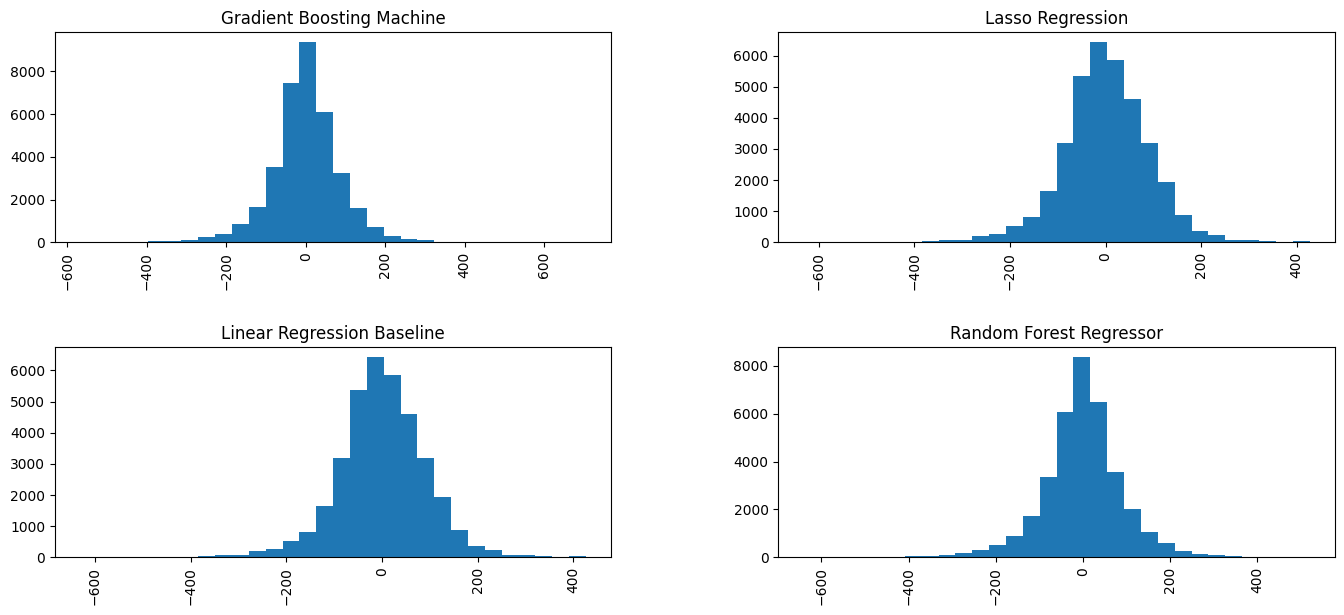

In [80]:
res_cv["error"] = res_cv["y_pred"] - res_cv["y_true"]

res_cv["error"].hist(by=res_cv["model"], figsize=(16, 7), bins=30),
plt.show()

In [81]:
res_cv.groupby("model").error.agg(
    [q5, "mean", "median", q95]
)

,q5,mean,median,q95
model,,,,
Gradient Boosting Machine,-141.338999,-0.093814,0.421166,136.083357
Lasso Regression,-148.062900,0.010801,-0.212513,142.226287
Linear Regression Baseline,-148.121410,0.010957,-0.245194,142.343645
Random Forest Regressor,-150.985788,-1.391245,0.929995,145.971180


<h4>Studying errors</h4>
<p>Here we will study how models compare to each other when predicting higher/smaller values of engine-off time.</p>

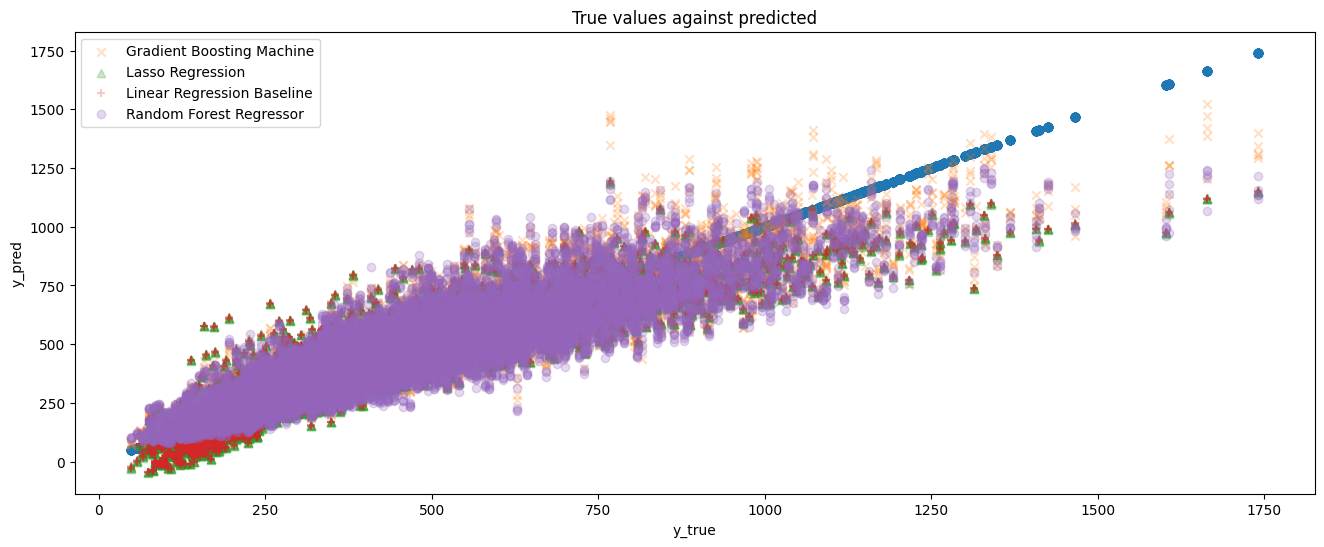

In [82]:
plt.figure(figsize=(16, 6))

plt.scatter(res_cv["y_true"], res_cv["y_true"])

markers = ["x", "^", "+", "o"]

for marker, group in zip(markers, res_cv.groupby("model")):
    name, df_group = group
    plt.scatter(
        df_group["y_true"], df_group["y_pred"], alpha=0.25,
        marker=marker, label=name
    )
    
plt.title("True values against predicted")
plt.xlabel("y_true")
plt.ylabel("y_pred")

plt.legend()
plt.show()

<p>The plot below is a bit messy, but still we observe that for values above .95 quantile, GBM is able to predict those better than others.</p>

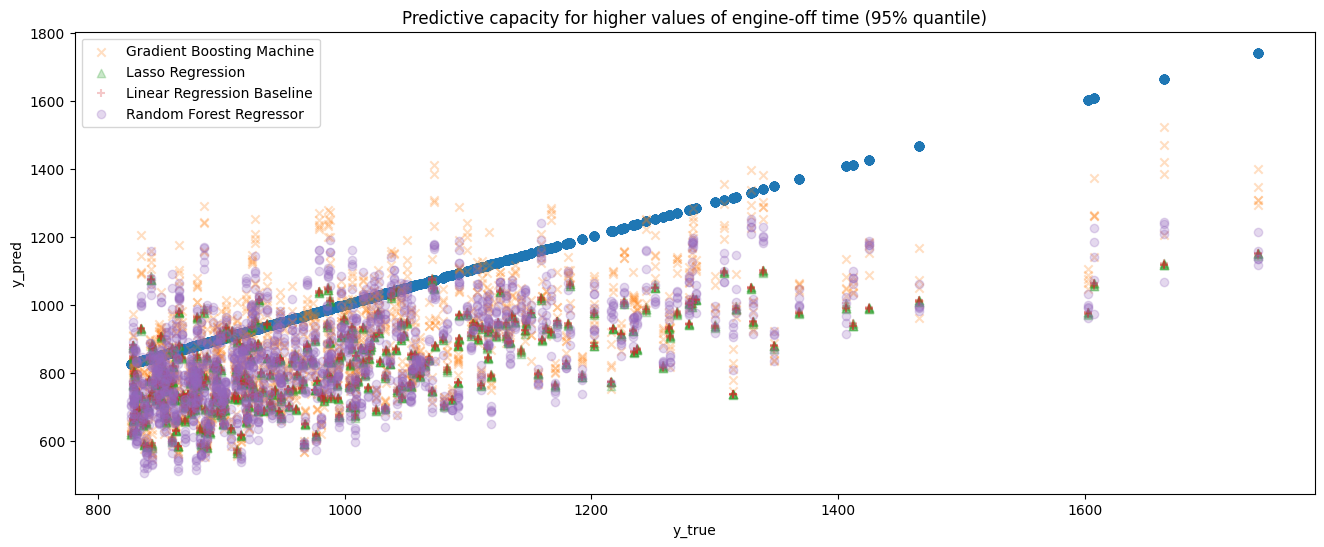

In [83]:
true_95 = res_cv[res_cv.y_true > res_cv.y_true.quantile(.95)]

plt.figure(figsize=(16, 6))

plt.scatter(true_95.y_true, true_95.y_true)

for marker, group in zip(markers, true_95.groupby("model")):
    name, df_group = group
    plt.scatter(
        df_group["y_true"], df_group["y_pred"], alpha=0.25,
        marker=marker, label=name
    )

plt.title("Predictive capacity for higher values of engine-off time (95% quantile)")
plt.xlabel("y_true")
plt.ylabel("y_pred")

plt.legend()
plt.savefig("models_res_95.png", bbox_inches="tight")
plt.show()

<p>Below we observe the table with MSE score for different models using only outliers in terms of engine-off time.</p>

In [84]:
true_95_res = []

for name, df_group in true_95.groupby("model"):
    true_95_res.append({
        "model": name,
        "mse": mean_squared_error(y_pred=df_group["y_pred"], y_true=df_group["y_true"]),
        "mae": mean_absolute_error(y_pred=df_group["y_pred"], y_true=df_group["y_true"]),
        "mape": mean_absolute_percentage_error(y_pred=df_group["y_pred"], y_true=df_group["y_true"])
    })
    
pd.DataFrame(true_95_res)

,model,mse,mae,mape
0,Gradient Boosting Machine,35106.954381,155.492432,0.154460
1,Lasso Regression,46333.779110,185.885569,0.181563
2,Linear Regression Baseline,46287.903058,185.772911,0.181451
3,Random Forest Regressor,40766.067979,167.484211,0.164749


In [85]:
quan_res = []

for quan in tqdm(np.linspace(1, 0, 100)):
    df_quan = res_cv[res_cv.y_true <= res_cv.y_true.quantile(quan)]
    for name, df_group in df_quan.groupby("model"):
        quan_res.append({
            "model": name,
            "mse": mean_squared_error(
                y_pred=df_group.y_pred, y_true=df_group.y_true
            ),
            "mape": mean_absolute_percentage_error(
                y_pred=df_group["y_pred"], y_true=df_group["y_true"]
            )
        })
        
quan_res = pd.DataFrame(quan_res)

100%|██████████| 100/100 [00:05<00:00, 18.71it/s]


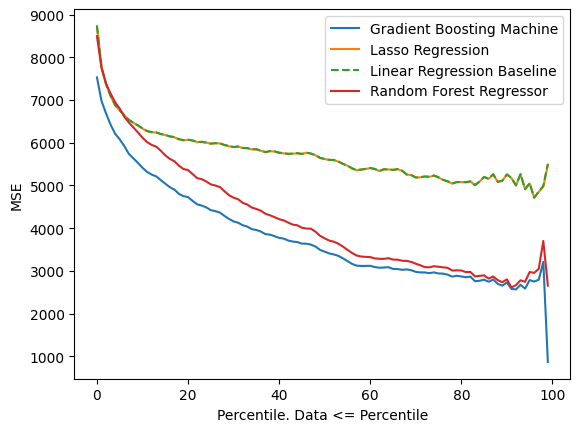

In [86]:
for name, df_group in quan_res.groupby("model"):
    plt.plot(
        range(100), df_group.mse, label=name, 
        linestyle="--" if name == "Linear Regression Baseline" else None
    )
    


plt.ylabel("MSE")
plt.xlabel("Percentile. Data <= Percentile")

plt.legend()
plt.show()

<h4>Choosing the best model</h4>
<p>We see that Gradient Boosting Machine outperforms other models. Summing up, after seeing that boosting gave us the lowest MAE, MAPE, MSE and highest R2 for the same of variables, we should definitely choose Gradient Boosting Machine (GBM) as our final model. On top of that it has the best performance for higher values of engine-off time.</p>

<h2>Task 4</h2>

<p><b>Task 4.1</b> Estefania would like to learn from the ML algorithm. What are the most
relevant features that define the engine-off time? Can you somehow quantify
how important each is or which are most useful?</p>

<h4>Feature importances and Permutation importances</h4>

<p>We might want to use Feauture importances which are defined as an overall impact of the variable towards improving the splits in the decision trees. By default squared error is used to measure how good the split is. Therefore, sum of all changes in squared_errors relative to overall decrease in SSE is defined as impact of the variables. The most significant variables will allow to decrease SSE the most.</p>

In [87]:
def bootstrap_tuned_model(
    model, df_train: pd.DataFrame, reg_cols, n_samples=1000,
) -> Dict[str, List[Any]]:
    
    feature_importances = []
    
    for _ in tqdm(range(n_samples)):
        df_sampled = df_train.sample(
            df.shape[0], replace=True
        )
        model.fit(df_sampled[reg_cols], df_sampled.final_time)
        
        feature_importances.append(
            model.feature_importances_
        )
        
    return np.array(feature_importances)

In [88]:
res_bs = bootstrap_tuned_model(gbm, df_train, reg_cols, n_samples=10)

100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


<h4>Feature importance</h4>

In [89]:
pd.DataFrame(
    res_bs.mean(axis=0), index=reg_cols, columns=["mean_feature_importance"]
).sort_values(by="mean_feature_importance", ascending=False).head(12)

,mean_feature_importance
box_count,0.621257
D98,0.075587
is_fresh_client,0.048708
D33,0.038908
Street level,0.037597
D13,0.032834
morning,0.027460
D63,0.026804
Other,0.014143
D16,0.013284


<p>The results above are very very good, they are in line with the second best model that we have (LASSO regression). The ordering of most impactful varibles is the same. The higher the value of feature_importance the more informative is the variable. 

<p><b>4.2</b>What can be done to
improve even more the model performance and achieve better results?</p>

<p>We might consider choosing boosting algorithms that use different approaches of building trees from GBM like LightGBM, XGBoost and CatBoost. We might also go heavy on hyperparameter tuning especially for CatBoost to find the best set of parameters this will allow to achieve an improvement in results by 3-5% but it will be computationally difficult we might need to get a GPU to train multiple models especially once we have more data.</p>

<p>Below we are using cyclical time encoding, previously we saw that hour column is significant meaning it has a lot of impact when predicting final engine-off time. By doing cyclical encoding we preserve measure of how close timestamps are to one another. It turned out way better than simple dummy encoding for morning, day, evening.</p>

<a href="https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/">Source to cyclic encoding</a> 

<h4>Below is everything related to competition. Further improvements</h4>

<ul>
    <li>Cyclic time encoding with sine and cosine</li>
    <li>XGBoost + Optuna</li>
    <li>CatBoost + Optuna</li>
    <li>Robust standardisation with Bootstrapped estimates of population mean and standard deviation</li>
    <li>Shapley values for CatBoost</li>
</ul>

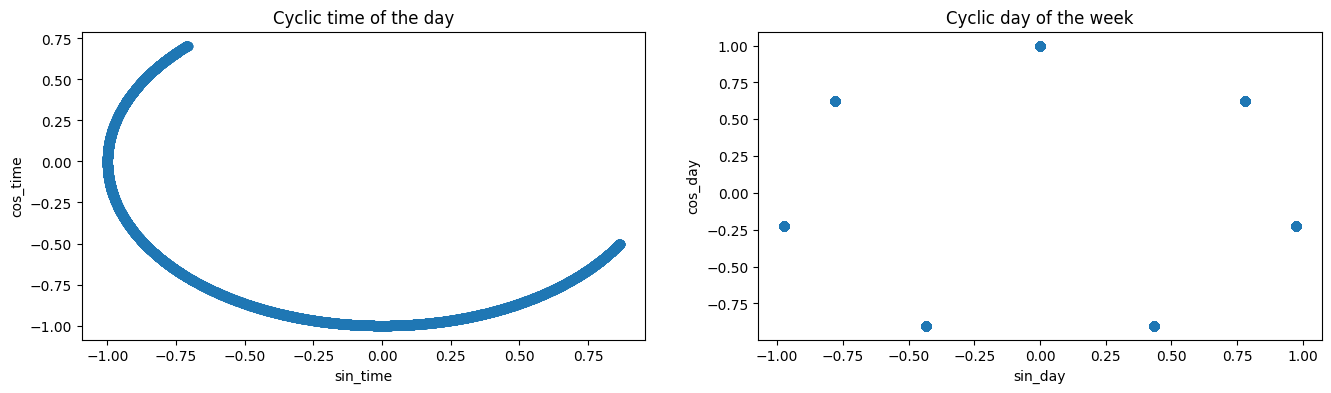

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
ax1, ax2 = axs

ax1.set_xlabel("sin_time")
ax1.set_ylabel("cos_time")
ax1.set_title("Cyclic time of the day")
ax1.scatter(df["sin_time"], df["cos_time"])

ax2.set_xlabel("sin_day")
ax2.set_ylabel("cos_day")
ax2.set_title("Cyclic day of the week")
ax2.scatter(df["sin_day"], df["cos_day"])

plt.show()

<p>Here instead of using dummy encoded time of the day features like is_morning, is_day, is_evening, we will use suggested cyclical sin and cos time. We will see that it will yield superior results with improvement of over 25% in terms all metrics.</p>

In [91]:
cyclic_cols = [
    "sin_time", "cos_time", "sin_day", "cos_day"
]

reg_cols = (
    ["box_count", "is_fresh_client"] + driver_cols + truck_cols + floor_cols + cyclic_cols
)

<h4>XGBoostRegressor + Optuna + Cyclic time</h4>

In [ ]:
#!pip install xgboost

In [92]:
import xgboost as xgb
import gc

In [93]:
def xgboost_objective(
    trial: optuna.Trial, df: pd.DataFrame, reg_cols: List[str], fold: RepeatedKFold
):
    xgb_params = {
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "eval_metric": ["rmse", "mae"],
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.00001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.00001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "gamma": trial.suggest_float("gamma", 0.01, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0, 1),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 2)
    }

    rmse_scores = []
    
    i = 0
    
    for train_idx, val_idx in fold.split(df[reg_cols], df["final_time"]):
        # split data to train and validation sets
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # train on train subset and use validation set to evaluate the model
        dtrain = xgb.DMatrix(df_train[reg_cols], label=df_train["final_time"])
        dval = xgb.DMatrix(df_val[reg_cols], label=df_val["final_time"])
        
        evals_result = {}
        
        # Fit the model with early stopping
        model = xgb.train(
            xgb_params, dtrain=dtrain, 
            evals=[(dtrain, "train"), (dval, "val")],
            num_boost_round=1000, early_stopping_rounds=50,
            verbose_eval=False, evals_result=evals_result
        )
        
        y_pred = model.predict(dval)
        best_val_score = min(evals_result["val"]["rmse"])
        
        # get the best rmse score on validation set
        rmse_scores.append(best_val_score)
        
        trial.report(best_val_score, i)

        if trial.should_prune():
            raise optuna.TrialPruned()
        
        del model, dtrain, dval, y_pred
        _ = gc.collect()
        
        i += 1

    return np.mean(rmse_scores)

<p>Here we are doing pruning with optuna. We basically stop if we observe a very bad result (below the median) for a given set of parameters for current fold. We don't need to retrain the model on multiple folds if a very bad result has already been encountered. This way we are saving on computation time. Bad trials will be pruned - stopped.</p>

In [94]:
study_xgboost = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)

study_xgboost.optimize(
    partial(xgboost_objective, df=df_train, reg_cols=reg_cols, fold=tune_fold), 
    n_trials=20
)

[I 2024-04-21 05:43:30,985] A new study created in memory with name: no-name-e31accc5-4c57-4925-9fb1-5a308e346e49
[I 2024-04-21 05:43:43,927] Trial 0 finished with value: 64.60726342300447 and parameters: {'learning_rate': 0.014632820563299322, 'max_depth': 6, 'reg_alpha': 0.0996302682140848, 'reg_lambda': 0.0004029750756271195, 'subsample': 0.7022689380215539, 'gamma': 0.7828633167755848, 'colsample_bytree': 0.7425859712215619, 'scale_pos_weight': 1.3589410906532327}. Best is trial 0 with value: 64.60726342300447.
[I 2024-04-21 05:43:50,288] Trial 1 finished with value: 66.12835169567565 and parameters: {'learning_rate': 0.029132684903477375, 'max_depth': 7, 'reg_alpha': 0.00024395131962791721, 'reg_lambda': 0.0010004395545746146, 'subsample': 0.9225270282163038, 'gamma': 0.3862383137445612, 'colsample_bytree': 0.8547840645497631, 'scale_pos_weight': 1.4419747320984078}. Best is trial 0 with value: 64.60726342300447.
[I 2024-04-21 05:43:52,739] Trial 2 finished with value: 66.79722003

<p>Since XGBoost (similiar will be with CatBoost) needs a separate validation set for early stopping we will use our custom crossvalidation function that will use same folds as previous in crossvalidations runs.</p>

In [95]:
def crossval_xgboost(
    xgb_params: dict, df: pd.DataFrame, fold: RepeatedKFold,
) -> float:
    
    scores = []
    xgb_params["eval_metric"] = ["mape", "mae", "rmse"]
    
    for train_idx, val_idx in fold.split(df[reg_cols], df["final_time"]):
        # split data to train and validation sets
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # train on train subset and use validation set to evaluate the model
        dtrain = xgb.DMatrix(df_train[reg_cols], label=df_train["final_time"])
        dval = xgb.DMatrix(df_val[reg_cols], label=df_val["final_time"])
        
        evals_result = {}
        
        # Fit the model with early stopping
        model = xgb.train(
            xgb_params, dtrain=dtrain, 
            evals=[(dtrain, "train"), (dval, "val")],
            num_boost_round=1000,
            early_stopping_rounds=50, verbose_eval=False,
            evals_result=evals_result
        )
        
        scores.append({
            "mae": min(evals_result["val"]["mae"]),
            "mape": min(evals_result["val"]["mape"]),
            "rmse": min(evals_result["val"]["rmse"])
        })
        
    return pd.DataFrame(scores)

In [96]:
res = crossval_xgboost(
    xgb_params=study_xgboost.best_params, 
    df=df_train, 
    fold=cv_fold
)

res.agg([q5, "median", "mean", q95])

,mae,mape,rmse
q5,41.567778,0.100108,61.010370
median,43.168732,0.105702,63.816904
mean,43.173768,0.104930,63.673793
q95,45.141012,0.107954,66.536078


<h4>Catboost + Optuna + Cyclic time</h4>

<p>Usually CatBoost is the best boosting algorithm but there is a trade-off as it takes generally more time to train. So we expect better results than XGBoost and way more computation time. I also tried using CatBoost with its built-in nifty categorical enconding (ordered target encoding) but it turned out to be slightly worse, I think it is a great tool when we have multiple categories and dummies is not the option to encode them since we will end up with millions of features which is bad.</p>

In [97]:
import catboost as cb
import optuna
import gc

from catboost import Pool, CatBoostRegressor

from functools import partial

In [98]:
def catboost_objective(
    trial: optuna.Trial, df: pd.DataFrame, fold: RepeatedKFold,
    reg_cols: List[str], cat_features: Union[List[str] | None] = None
):
    
    cb_params = {
        "objective": "MAPE",
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'depth': trial.suggest_int('depth', 2, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.00001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "eval_metric": "MAPE",
        "random_seed": 42,
    }

    scores = []
    i = 0
    
    for train_idx, val_idx in fold.split(df[reg_cols], df["final_time"]):
        # split data to train and validation sets
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        
        # train on train subset and use validation set to evaluate the model
        train = Pool(data=df_train[reg_cols], label=df_train["final_time"])
        val = Pool(data=df_val[reg_cols], label=df_val["final_time"])
        
        # Fit the model with early stopping
        model = CatBoostRegressor(**cb_params)
        
        model.fit(
            train,
            eval_set=val,
            use_best_model=True,
            early_stopping_rounds=200,
            verbose=False,
        )
        
        rmse = model.best_score_["validation"]["MAPE"]
        scores.append(rmse)
        
        trial.report(rmse, i)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        del model
        _ = gc.collect()
        
        i += 1

    return np.mean(scores)

In [ ]:
study_catboost = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)

study_catboost.optimize(
    partial(catboost_objective, df=df_train, reg_cols=reg_cols, fold=tune_fold), 
    n_trials=20
)

In [100]:
# create a split early stopping validation set
cb_train, cb_val = train_test_split(df_train, train_size=0.9, random_state=42, shuffle=True)
# create Pools for catboost
train = Pool(data=cb_train[reg_cols], label=cb_train["final_time"])
val = Pool(data=cb_val[reg_cols], label=cb_val["final_time"])

In [101]:
model_catboost = cb.CatBoostRegressor(
    objective="RMSE",
    **study_catboost.best_params
)

model_catboost.fit(
    train, eval_set=val,
    use_best_model=True,
    early_stopping_rounds=200,
    verbose=False,
)

<h4>Crossvalidate CatBoost with same CV Folds</h4>

In [102]:
def crossval_catboost(
    cb_params: dict, df: pd.DataFrame, reg_cols: List[str], fold: RepeatedKFold,
) -> float:
    
    scores = []
    cb_params["custom_metric"] = ["MAE", "RMSE"]
    
    for train_idx, val_idx in fold.split(df[reg_cols], df["final_time"]):
        # split data to train and validation sets
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # train on train subset and use validation set to evaluate the model
        train = Pool(data=df_train[reg_cols], label=df_train["final_time"])
        val = Pool(data=df_val[reg_cols], label=df_val["final_time"])
        
        model = CatBoostRegressor(**cb_params)
        
        model.fit(
            train, eval_set=val,
            use_best_model=True,
            early_stopping_rounds=200,
            verbose=False,
        )
        
        y_pred = model.predict(val)
        
        res = model.get_best_score()["validation"]
        res.update({
            "MAPE": mean_absolute_percentage_error(y_pred=y_pred, y_true=df_val["final_time"])
        })
        
        scores.append(
            res
        )
        
    return pd.DataFrame(scores)

In [103]:
res_catboost = crossval_catboost(
    cb_params=study_catboost.best_params,
    df=df_train,
    reg_cols=reg_cols,
    fold=cv_fold
)

In [104]:
res_catboost.agg([q5, "mean", "median", q95])

,MAE,RMSE,MAPE
q5,41.344076,61.835152,0.099698
mean,43.448720,65.495030,0.103086
median,43.584655,65.532344,0.103293
q95,45.343069,69.776329,0.107130


<h4>Additionally</h4>

<p>This might be a great one. I do scaling of the data to help algorithms to converge fast, but this way I make very brave assumptions about the distributions of the data, namely their mean and std, therefore when dealing with out of sample data I might get absolutely different results due to incorrect scaling. To account for this we might use bootstrapped estimates for population mean and standard deviation and use these instead of sample ones. This way we will most likely not arrive at the situation when mean and std of out of sample data is entirely different from ones we used for training.</p>

In [105]:
def bootstrap_distr(
    df: pd.DataFrame, num_cols: List[str], n_samples: int = 1000
) -> pd.DataFrame:
    
    data = []
    
    for _ in tqdm(range(n_samples)):
        for col in num_cols:
            sampled_vals = np.random.choice(df[col].values, size=df.shape[0], replace=True)
            mean, std = sampled_vals.mean(), sampled_vals.std()
            data.append({
                "num_col": col, "mean": mean, "std": std
            })
    
    return pd.DataFrame(data)   

In [106]:
df_bs = bootstrap_distr(df, num_cols, n_samples=10000)

100%|██████████| 10000/10000 [00:05<00:00, 1924.22it/s]


In [107]:
df_bs.groupby("num_col").mean()

,mean,std
num_col,,
box_count,7.363343,4.408011
order_entropy,0.612576,0.254414
total_weight,62.574156,32.904490


<p>Let's compare what we used to scale our data with bootstrapped estimates.</p>

In [108]:
df[num_cols].mean(axis=0), df[num_cols].std(axis=0)

(total_weight     62.570673
 box_count         7.362667
 order_entropy     0.612572
 dtype: float64,
 total_weight     32.909144
 box_count         4.408977
 order_entropy     0.254442
 dtype: float64)

<p>Well, it is close enough, therefore, let's leave it as is.</p>

<h4>Shapley values as feature importance</h4>

In [ ]:
# !pip install shap

In [109]:
df_train["is_fresh_client"] = df_train["is_fresh_client"].astype(int)

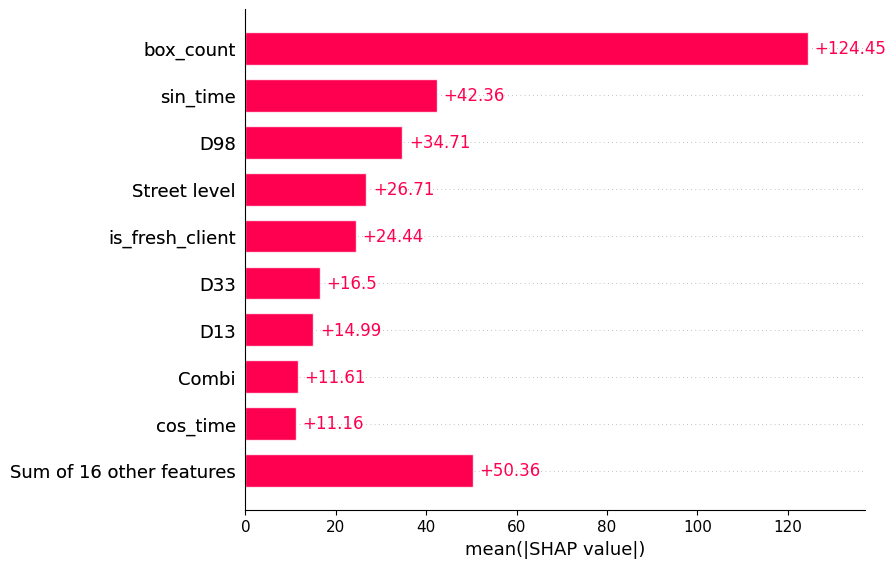

In [110]:
import shap

explainer = shap.TreeExplainer(model_catboost)
shap_values = explainer(df_train[reg_cols])

# visualize the first prediction's explanation
shap.plots.bar(shap_values)